LSTM Stock Price Predictor

In [46]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from keras import models, layers

In [40]:
import yfinance as yf

spy = yf.download('SPY', start='2010-01-01', end='2023-01-01')

training_data = spy['Close']['2010-01-01':'2020-12-31']
validation_data = spy['Close']['2021-01-01':'2023-01-01']

training_set = training_data.values.reshape(-1, 1)
validation_set = validation_data.values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


In [41]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.transform(validation_set)

In [44]:
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(validation_set_scaled)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

In [47]:
model = models.Sequential()
model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0237 - val_loss: 0.0319
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0038 - val_loss: 0.0073
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0027 - val_loss: 0.0063
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0021 - val_loss: 0.0139
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

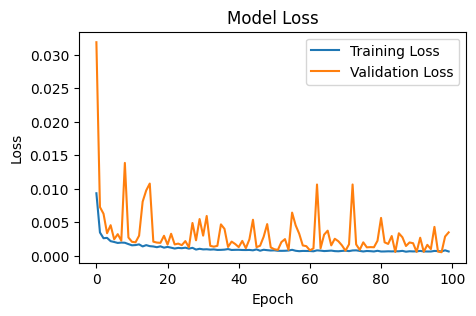

In [51]:
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
#usage
spy_test = yf.download('SPY', start='2023-01-01', end='2023-07-31')
real_stock_price = spy_test['Close'].values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


In [54]:
dataset_total = pd.concat((spy['Close'], spy_test['Close']), axis=0)
inputs = dataset_total[len(dataset_total) - len(spy_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [56]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 


array([[362.39526],
       [362.46667],
       [363.17575],
       [362.51175],
       [364.3144 ],
       [366.2291 ],
       [368.25565],
       [371.05518],
       [373.435  ],
       [375.23196],
       [375.9489 ],
       [374.18997],
       [371.64932],
       [372.19516],
       [375.07428],
       [377.31796],
       [378.37738],
       [379.96878],
       [381.31882],
       [380.4439 ],
       [381.22104],
       [383.56882],
       [387.33484],
       [388.38004],
       [387.46677],
       [388.18115],
       [387.62485],
       [385.94656],
       [385.01886],
       [386.23123],
       [387.44293],
       [388.5038 ],
       [387.15286],
       [385.40213],
       [381.70197],
       [378.85815],
       [378.0856 ],
       [376.8996 ],
       [376.40295],
       [375.74054],
       [374.72705],
       [374.90378],
       [377.34775],
       [379.51138],
       [378.66632],
       [377.5441 ],
       [374.56448],
       [370.6178 ],
       [367.82895],
       [368.499  ],


NameError: name 'mdates' is not defined

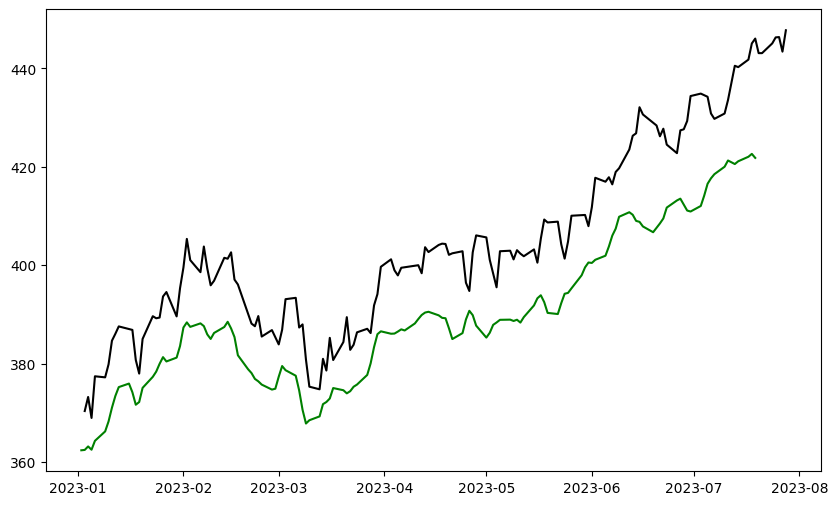

In [59]:
date_range = pd.date_range(start='2023-01-01', periods=len(predicted_stock_price), freq='B')  # 'B' for business day frequency

# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(10, 6))
plt.plot(spy_test.index, real_stock_price, color='black', label='SPY Stock Price')
plt.plot(date_range, predicted_stock_price, color='green', label='Predicted SPY Stock Price')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed

Running prediction for SPY...
Loading and preparing SPY data...
Building and training LSTM model...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0389 - val_loss: 0.0127
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0030 - val_loss: 0.0209
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026 - val_loss: 0.0086
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020 - val_loss: 0.0215
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0023 - val_loss: 0.0126
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step

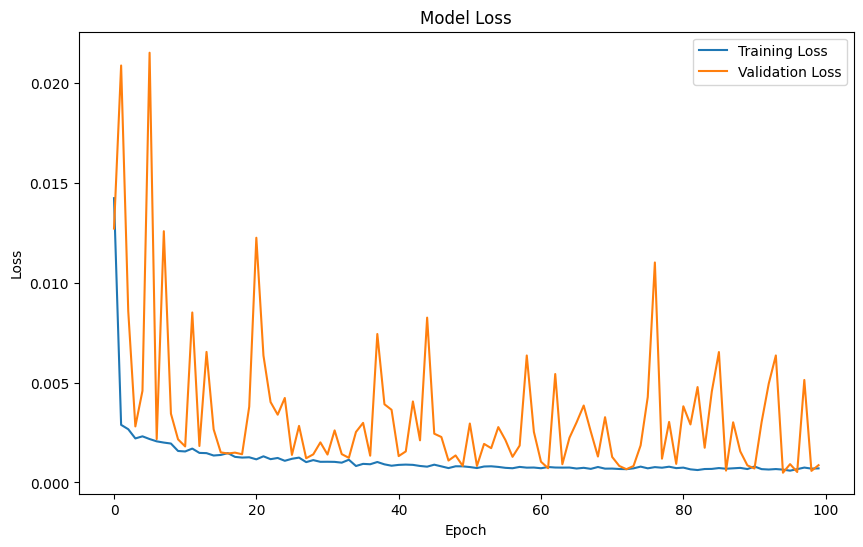

Preparing latest SPY data for prediction...


[*********************100%***********************]  1 of 1 completed

Predicting prices for the next 12 months...


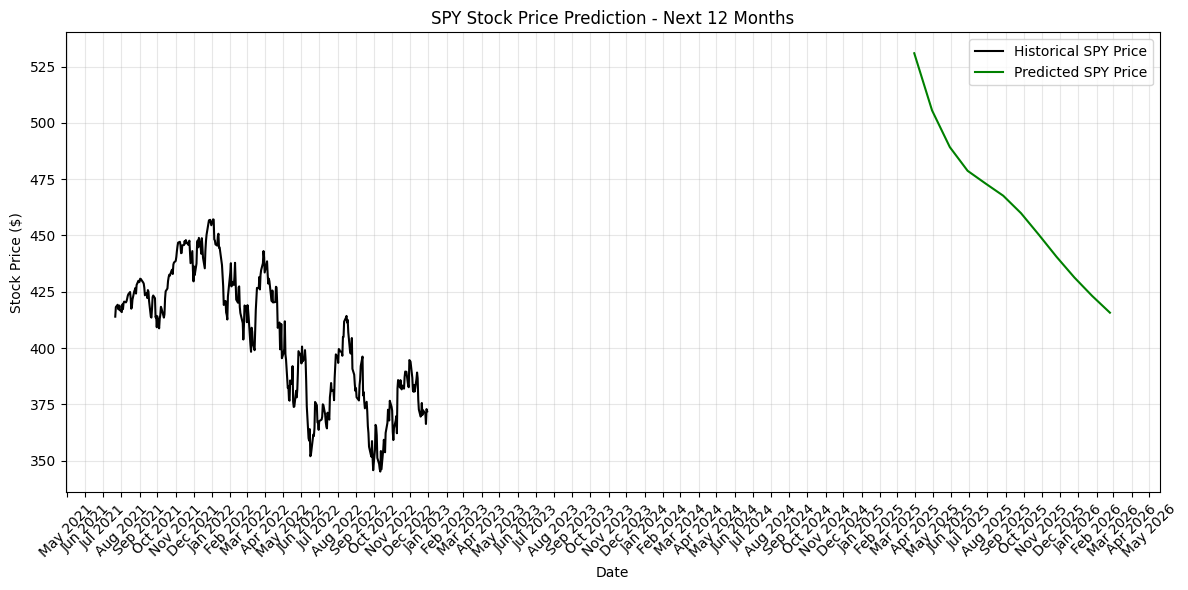

[*********************100%***********************]  1 of 1 completed


SPY Monthly Price Predictions:
----------------------------------------
Month           Predicted Price
----------------------------------------
Mar 2025        $530.92        
Apr 2025        $505.55        
May 2025        $489.23        
Jun 2025        $478.72        
Jul 2025        $473.12        
Aug 2025        $467.67        
Sep 2025        $459.92        
Oct 2025        $450.38        
Nov 2025        $440.52        
Dec 2025        $431.37        
Jan 2026        $423.18        
Feb 2026        $415.73        

Running prediction for AAPL...
Loading and preparing AAPL data...
Building and training LSTM model...
Epoch 1/100



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0159 - val_loss: 0.0105
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 0.0068
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - val_loss: 0.0056
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010 - val_loss: 0.0061
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 9.7793e-04 - val_loss: 0.0064
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.3452e-04 - val_loss: 0.0043
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.5391e-04 - val_loss: 0.0104
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010 - val_loss: 0.0033
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5226e-04 - val_loss: 0.0034
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/

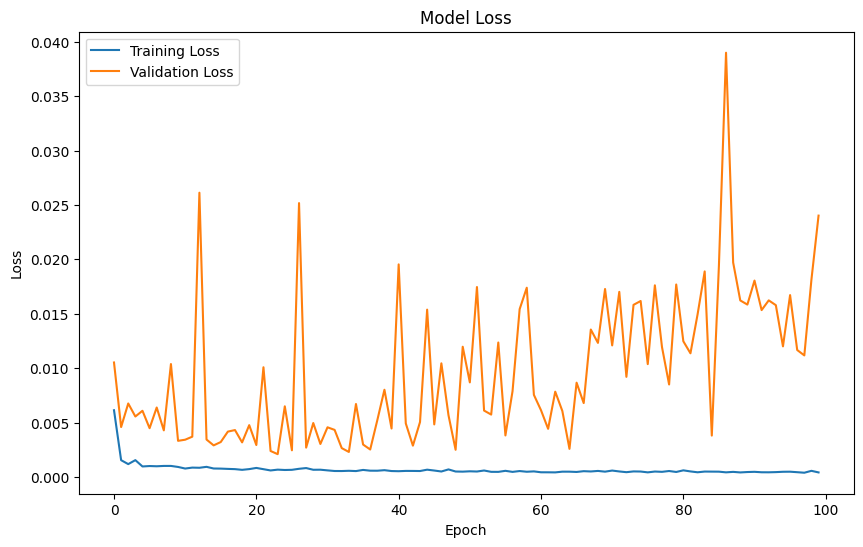

Preparing latest AAPL data for prediction...


[*********************100%***********************]  1 of 1 completed

Predicting prices for the next 12 months...


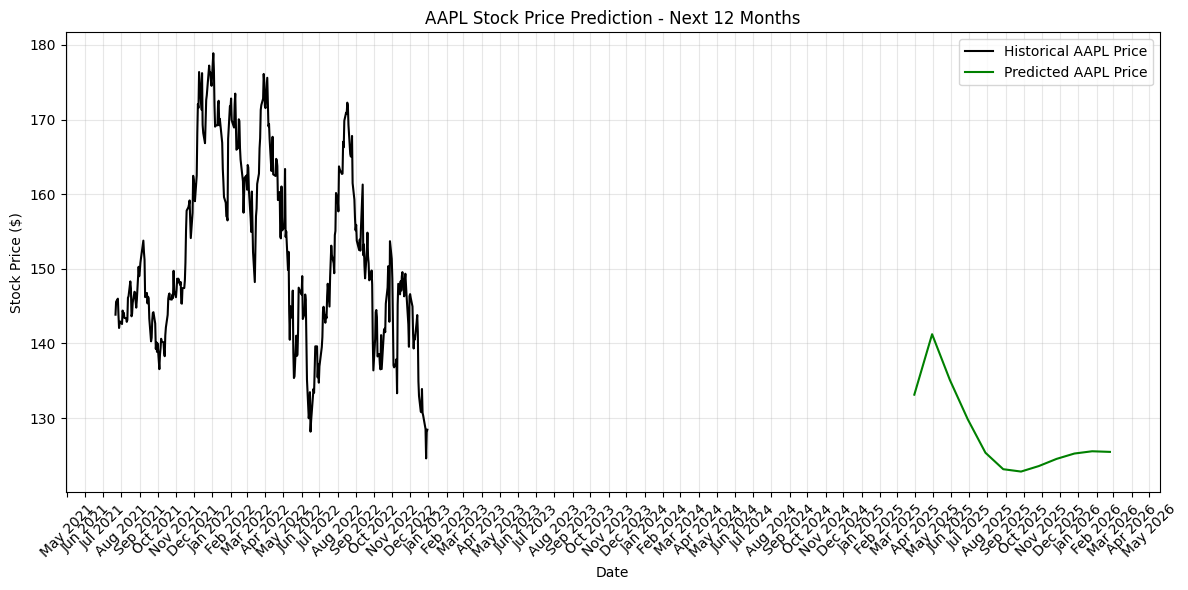


AAPL Monthly Price Predictions:
----------------------------------------
Month           Predicted Price
----------------------------------------
Mar 2025        $133.13        
Apr 2025        $141.23        
May 2025        $135.10        
Jun 2025        $129.85        
Jul 2025        $125.35        
Aug 2025        $123.14        
Sep 2025        $122.83        
Oct 2025        $123.56        
Nov 2025        $124.53        
Dec 2025        $125.24        
Jan 2026        $125.55        
Feb 2026        $125.46        


In [60]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models, layers
from datetime import datetime, timedelta

# Function to create sequences for LSTM
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Load and prepare historical data
def prepare_stock_data(ticker, train_start='2010-01-01', train_end='2020-12-31',
                      val_start='2021-01-01', val_end='2023-01-01'):
    data = yf.download(ticker, start=train_start, end=val_end)

    training_data = data['Close'][train_start:train_end]
    validation_data = data['Close'][val_start:val_end]

    training_set = training_data.values.reshape(-1, 1)
    validation_set = validation_data.values.reshape(-1, 1)

    sc = MinMaxScaler(feature_range=(0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    validation_set_scaled = sc.transform(validation_set)

    X_train, y_train = create_sequences(training_set_scaled)
    X_validation, y_validation = create_sequences(validation_set_scaled)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

    return X_train, y_train, X_validation, y_validation, sc, data

# Build and train LSTM model
def build_and_train_model(X_train, y_train, X_validation, y_validation, epochs=100, batch_size=32):
    model = models.Sequential()
    model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(units=50, return_sequences=True))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(units=50, return_sequences=True))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(units=50))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        verbose=1
    )

    return model, history

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to get the latest data and prepare it for prediction
def prepare_latest_data(ticker, sc, seq_length=60):
    # Get the current date
    today = datetime.now().strftime('%Y-%m-%d')

    # Calculate the date range needed for sequence preparation
    start_date = (datetime.now() - timedelta(days=seq_length * 2)).strftime('%Y-%m-%d')

    # Download the latest data
    latest_data = yf.download(ticker, start=start_date, end=today)

    # Take the last 'seq_length' data points
    latest_prices = latest_data['Close'].values.reshape(-1, 1)
    latest_prices_scaled = sc.transform(latest_prices)

    # Create the input sequence
    X_latest = []
    X_latest.append(latest_prices_scaled[-seq_length:, 0])
    X_latest = np.array(X_latest)
    X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

    return X_latest, latest_data

# Function to predict next 12 months
def predict_next_12_months(model, X_latest, sc, seq_length=60):
    # Start with the latest sequence
    current_sequence = X_latest[0]

    # List to store predictions
    predictions = []

    # Current date for reference
    current_date = datetime.now()
    future_dates = []

    # Make predictions for the next 12 months
    for i in range(12):
        # Month-end date (approximate - using 30 days for simplicity)
        future_date = (current_date + timedelta(days=30 * (i + 1)))
        future_dates.append(future_date)

        # Reshape for prediction
        current_batch = current_sequence[-seq_length:].reshape(1, seq_length, 1)

        # Predict next value
        next_pred = model.predict(current_batch, verbose=0)

        # Store the prediction
        predictions.append(next_pred[0, 0])

        # Update sequence for next prediction (rolling window)
        current_sequence = np.append(current_sequence, next_pred[0, 0])

    # Convert predictions back to original scale
    predictions_array = np.array(predictions).reshape(-1, 1)
    predictions_rescaled = sc.inverse_transform(predictions_array)

    return predictions_rescaled, future_dates

# Function to plot historical data and future predictions
def plot_predictions(historical_data, predictions, future_dates, ticker):
    plt.figure(figsize=(12, 6))

    # Plot historical data
    plt.plot(historical_data.index[-365:], historical_data['Close'][-365:],
             color='black', label=f'Historical {ticker} Price')

    # Plot predictions
    plt.plot(future_dates, predictions, color='green', label=f'Predicted {ticker} Price')

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    plt.title(f'{ticker} Stock Price Prediction - Next 12 Months')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

def print_monthly_predictions(predictions, future_dates, ticker):
    print(f"\n{ticker} Monthly Price Predictions:")
    print("-" * 40)
    print(f"{'Month':<15} {'Predicted Price':<15}")
    print("-" * 40)

    for i in range(len(predictions)):
        month_str = future_dates[i].strftime('%b %Y')
        price_str = f"${predictions[i][0]:.2f}"
        print(f"{month_str:<15} {price_str:<15}")

# Main execution function
def run_stock_prediction(ticker='AAPL'):
    print(f"Loading and preparing {ticker} data...")
    X_train, y_train, X_validation, y_validation, scaler, historical_data = prepare_stock_data(ticker)

    print("Building and training LSTM model...")
    model, history = build_and_train_model(X_train, y_train, X_validation, y_validation)

    # Plot training results
    plot_loss(history)

    print(f"Preparing latest {ticker} data for prediction...")
    latest_sequence, latest_data = prepare_latest_data(ticker, scaler)

    print("Predicting prices for the next 12 months...")
    predictions, future_dates = predict_next_12_months(model, latest_sequence, scaler)

    # Plot predictions
    plot_predictions(historical_data, predictions, future_dates, ticker)

    # Print monthly predictions
    print_monthly_predictions(predictions, future_dates, ticker)

    return predictions, future_dates

# Run the prediction for SPY first as in the example
print("Running prediction for SPY...")
spy_predictions, spy_dates = run_stock_prediction('SPY')

# Run the prediction for AAPL as requested
print("\nRunning prediction for AAPL...")
aapl_predictions, aapl_dates = run_stock_prediction('AAPL')